# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [ ]:
bbri_hist = pd.read_csv("/content/drive/MyDrive/Final Project/dataset-3/Dataset_Bank/historical_value/bbri_hist.csv")
bbtn_hist = pd.read_csv("/content/drive/MyDrive/Final Project/dataset-3/Dataset_Bank/historical_value/bbtn_hist.csv")

#Testing Bank 1

In [ ]:
# Bank BBRI
# Mengonversi kolom 'date' menjadi tipe data datetime
bbri_hist['Date'] = pd.to_datetime(bbri_hist['Date'])
# Mengambil bagian tanggal saja dan mengatur hasilnya sebagai indeks data
bbri_hist.index = bbri_hist['Date'].dt.date

In [ ]:
# Mengambil kolom close
bbri_hist2 = bbri_hist.copy()

In [ ]:
# Train-Test Split
train_size = int(len(bbri_hist2) * 0.80)
test_size = len(bbri_hist2) - train_size
train_data_bbri_gru, test_data_bbri_gru = bbri_hist2[:train_size], bbri_hist2[train_size:]

In [ ]:
test_data_bbri_gru.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2022-03-25,2022-03-25 00:00:00+07:00,4251.291679,4251.291679,4153.047544,4206.635254,137104800,0.0,0.0
2022-03-28,2022-03-28 00:00:00+07:00,4224.497559,4233.428843,4170.909852,4224.497559,106801800,0.0,0.0
2022-03-29,2022-03-29 00:00:00+07:00,4242.360168,4242.360168,4170.909892,4188.772461,93155100,0.0,0.0
2022-03-30,2022-03-30 00:00:00+07:00,4233.429109,4233.429109,4188.772684,4206.635254,83364400,0.0,0.0
2022-03-31,2022-03-31 00:00:00+07:00,4197.703653,4242.360075,4161.978516,4161.978516,158650000,0.0,0.0


In [ ]:
test_data_bbri_gru.to_csv('bbri_predict.csv', index=False)

##Predict satu hari

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
df = test_data_bbri_gru.copy()
# 1. Load model
model = load_model('/content/best_model_bbri_gru_l3.h5')

# 2. Prepare data (gunakan data dari 30 hari terakhir)
last_n_days = 100  # Menggunakan 30 hari terakhir sebagai contoh
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict
predicted_scaled = model.predict(data_to_predict_scaled)

# 6. Inverse scaling
predicted = scaler.inverse_transform(predicted_scaled)

# Print the predicted value
print("\nPredicted value for the next day:")
print(predicted[0][0])

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1]

# Membuat DataFrame baru untuk hasil prediksi
prediction_date = last_date + pd.Timedelta(days=1)
prediction_df = pd.DataFrame({'Date': [prediction_date], 'Predicted_Close': predicted[0]})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)

1/1 [==============================] - 1s 1s/step

Predicted value for the next day:
5448.044

Prediction DataFrame:
                       Date  Predicted_Close
0 2024-04-19 00:00:00+07:00      5448.043945


##Predict beberapa hasi kedepan

In [ ]:
pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 7.6 MB/s eta 0:00:00


Using Best Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from pytz import timezone

df = test_data_bbri_gru.copy()

# Menampilkan 5 baris pertama dari DataFrame
print("DataFrame awal:")
print(df.head())

# Menampilkan 5 baris terakhir dari DataFrame
print("\nDataFrame akhir:")
print(df.tail())

# 1. Load model
model = load_model('/content/best_model_bbri_gru_l3.h5')

# 2. Prepare data (gunakan data dari 100 hari terakhir)
last_n_days = 100  # Menggunakan 100 hari terakhir sesuai kebutuhan model
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict multiple business days into the future, skipping weekends and holidays
n_days_to_predict = 30
predictions = []

# Get Jakarta (WIB) timezone
wib_timezone = timezone('Asia/Jakarta')

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get next business day from the last available date in the dataframe
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta
current_date = last_date

# List to hold predicted dates
predicted_dates = []

for _ in range(n_days_to_predict):
    # Get next business day
    current_date = nyse.valid_days(start_date=current_date + pd.Timedelta(days=1), end_date=current_date + pd.Timedelta(days=30), tz='Asia/Jakarta')[0]

    # Predict only if it's a business day
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        # Predict
        predicted_scaled = model.predict(data_to_predict_scaled)
        predicted = scaler.inverse_transform(predicted_scaled)

        # Save prediction
        predictions.append(predicted[0][0])

        # Update data_to_predict_scaled for the next prediction
        data_to_predict_scaled = np.append(data_to_predict_scaled[:, 1:, :], np.reshape(predicted_scaled, (1, 1, 1)), axis=1)

        # Save predicted date
        predicted_dates.append(current_date)

# Print the predicted values
print("\nPredicted values for the next business days:")
print(predictions)

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta

# Membuat DataFrame baru untuk hasil prediksi
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Close': predictions})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)


prediction_df.to_csv('bbri_predict.csv', index=False)


DataFrame awal:
                                Date         Open         High          Low  \
Date                                                                          
2022-03-25 2022-03-25 00:00:00+07:00  4251.291679  4251.291679  4153.047544   
2022-03-28 2022-03-28 00:00:00+07:00  4224.497559  4233.428843  4170.909852   
2022-03-29 2022-03-29 00:00:00+07:00  4242.360168  4242.360168  4170.909892   
2022-03-30 2022-03-30 00:00:00+07:00  4233.429109  4233.429109  4188.772684   
2022-03-31 2022-03-31 00:00:00+07:00  4197.703653  4242.360075  4161.978516   

                  Close     Volume  Dividends  Stock Splits  
Date                                                         
2022-03-25  4206.635254  137104800        0.0           0.0  
2022-03-28  4224.497559  106801800        0.0           0.0  
2022-03-29  4188.772461   93155100        0.0           0.0  
2022-03-30  4206.635254   83364400        0.0           0.0  
2022-03-31  4161.978516  158650000        0.0           0.

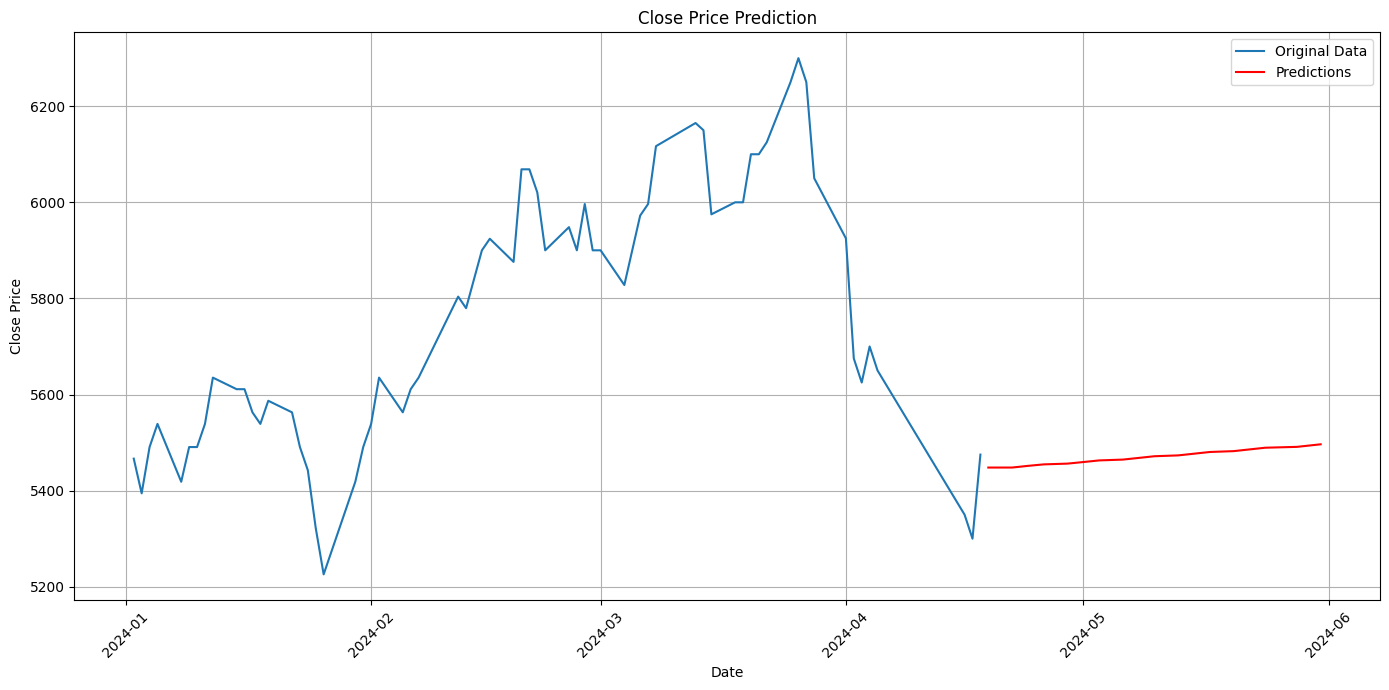

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(df[df['Date'] > '2024-01-01']['Date'], df[df['Date'] > '2024-01-01']['Close'], label='Original Data')

# Plot the predictions
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predictions', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Using Worst Model

DataFrame awal:
                                Date         Open         High          Low  \
Date                                                                          
2022-03-25 2022-03-25 00:00:00+07:00  4251.291679  4251.291679  4153.047544   
2022-03-28 2022-03-28 00:00:00+07:00  4224.497559  4233.428843  4170.909852   
2022-03-29 2022-03-29 00:00:00+07:00  4242.360168  4242.360168  4170.909892   
2022-03-30 2022-03-30 00:00:00+07:00  4233.429109  4233.429109  4188.772684   
2022-03-31 2022-03-31 00:00:00+07:00  4197.703653  4242.360075  4161.978516   

                  Close     Volume  Dividends  Stock Splits  
Date                                                         
2022-03-25  4206.635254  137104800        0.0           0.0  
2022-03-28  4224.497559  106801800        0.0           0.0  
2022-03-29  4188.772461   93155100        0.0           0.0  
2022-03-30  4206.635254   83364400        0.0           0.0  
2022-03-31  4161.978516  158650000        0.0           0.

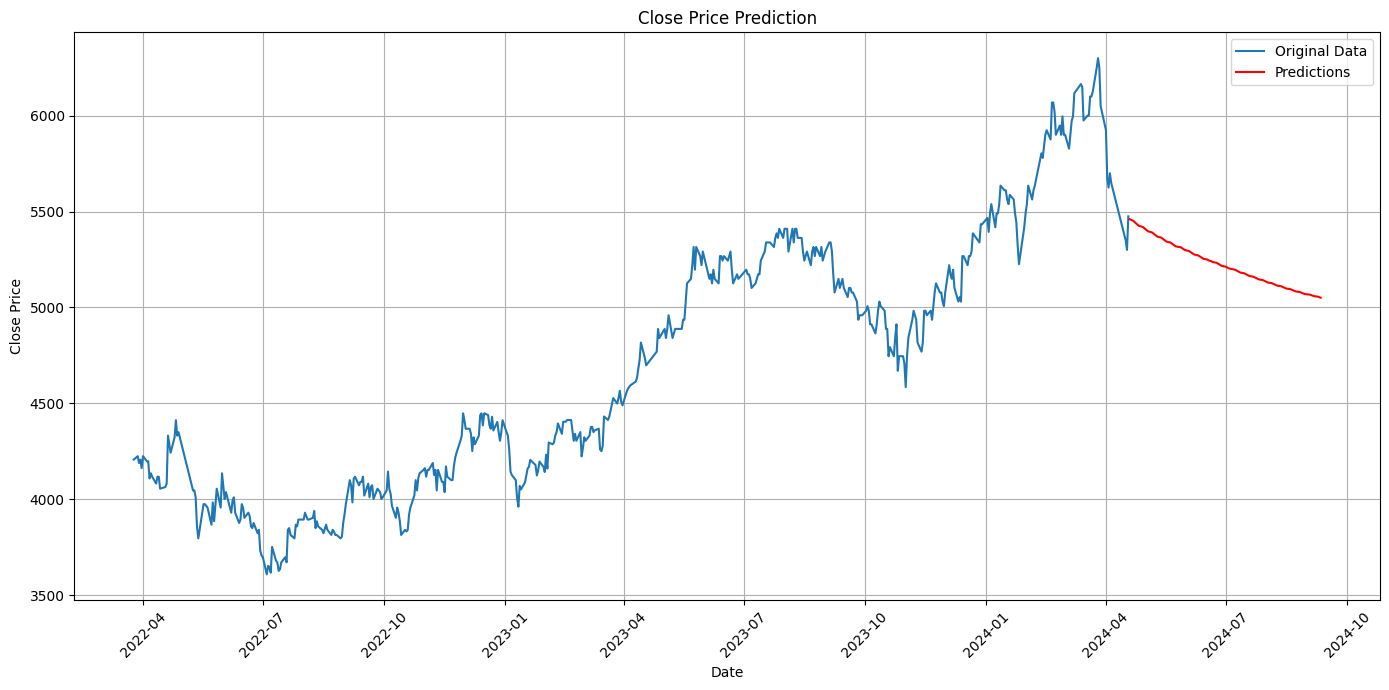

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from pytz import timezone

df = test_data_bbri_gru.copy()

# Menampilkan 5 baris pertama dari DataFrame
print("DataFrame awal:")
print(df.head())

# Menampilkan 5 baris terakhir dari DataFrame
print("\nDataFrame akhir:")
print(df.tail())

# 1. Load model
model = load_model('/content/worst_model_bbri_gru_l3.h5')

# 2. Prepare data (gunakan data dari 100 hari terakhir)
last_n_days = 100  # Menggunakan 100 hari terakhir sesuai kebutuhan model
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict multiple business days into the future, skipping weekends and holidays
n_days_to_predict = 100
predictions = []

# Get Jakarta (WIB) timezone
wib_timezone = timezone('Asia/Jakarta')

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get next business day from the last available date in the dataframe
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta
current_date = last_date

# List to hold predicted dates
predicted_dates = []

for _ in range(n_days_to_predict):
    # Get next business day
    current_date = nyse.valid_days(start_date=current_date + pd.Timedelta(days=1), end_date=current_date + pd.Timedelta(days=30), tz='Asia/Jakarta')[0]

    # Predict only if it's a business day
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        # Predict
        predicted_scaled = model.predict(data_to_predict_scaled)
        predicted = scaler.inverse_transform(predicted_scaled)

        # Save prediction
        predictions.append(predicted[0][0])

        # Update data_to_predict_scaled for the next prediction
        data_to_predict_scaled = np.append(data_to_predict_scaled[:, 1:, :], np.reshape(predicted_scaled, (1, 1, 1)), axis=1)

        # Save predicted date
        predicted_dates.append(current_date)

# Print the predicted values
print("\nPredicted values for the next business days:")
print(predictions)

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta

# Membuat DataFrame baru untuk hasil prediksi
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Close': predictions})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(df['Date'], df['Close'], label='Original Data')

# Plot the predictions
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predictions', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


#Testing Bank 2

In [ ]:
# Bank BBTN
# Mengonversi kolom 'date' menjadi tipe data datetime
bbtn_hist['Date'] = pd.to_datetime(bbtn_hist['Date'])
# Mengambil bagian tanggal saja dan mengatur hasilnya sebagai indeks data
bbtn_hist.index = bbtn_hist['Date'].dt.date

In [ ]:
# Mengambil kolom close
bbtn_hist2 = bbtn_hist.copy()

In [ ]:
# Train-Test Split
train_size = int(len(bbtn_hist2) * 0.80)
test_size = len(bbtn_hist2) - train_size
train_data_bbtn_gru, test_data_bbtn_gru = bbtn_hist2[:train_size], bbtn_hist2[train_size:]

# Scalling data
# scaler = MinMaxScaler()
# bbtn_hist2 = scaler.fit_transform(np.array(bbtn_hist2).reshape(-1,1))
# train_data_bbtn_gru = scaler.fit_transform(np.array(train_data_bbtn_gru).reshape(-1, 1))
# test_data_bbtn_gru = scaler.transform(np.array(test_data_bbtn_gru).reshape(-1, 1))

In [ ]:
test_data_bbtn_gru.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2022-03-25,2022-03-25 00:00:00+07:00,1454.558068,1454.558068,1413.235389,1433.896729,14325027,0.0,0.0
2022-03-28,2022-03-28 00:00:00+07:00,1446.293579,1466.954919,1429.764507,1446.293579,15658881,0.0,0.0
2022-03-29,2022-03-29 00:00:00+07:00,1458.690440,1479.351781,1442.161367,1450.425903,25615284,0.0,0.0
2022-03-30,2022-03-30 00:00:00+07:00,1446.293542,1458.690345,1421.499934,1425.632202,12918121,0.0,0.0
2022-03-31,2022-03-31 00:00:00+07:00,1425.632212,1438.029015,1417.367676,1417.367676,5908353,0.0,0.0


##Predict satu hari

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
df = test_data_bbtn_gru.copy()

# 1. Load model
model = load_model('/content/best_model_bbtn_gru_l5.h5')

# 2. Prepare data (gunakan data dari 30 hari terakhir)
last_n_days = 100  # Menggunakan 30 hari terakhir sebagai contoh
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict
predicted_scaled = model.predict(data_to_predict_scaled)

# 6. Inverse scaling
predicted = scaler.inverse_transform(predicted_scaled)

# Print the predicted value
print("\nPredicted value for the next day:")
print(predicted[0][0])

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1]

# Membuat DataFrame baru untuk hasil prediksi
prediction_date = last_date + pd.Timedelta(days=1)
prediction_df = pd.DataFrame({'Date': [prediction_date], 'Predicted_Close': predicted[0]})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)

1/1 [==============================] - 3s 3s/step

Predicted value for the next day:
1406.6005

Prediction DataFrame:
                       Date  Predicted_Close
0 2024-04-19 00:00:00+07:00      1406.600464


##Predict beberapa hasi kedepan

Using Best Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from pytz import timezone

df = test_data_bbtn_gru.copy()

# Menampilkan 5 baris pertama dari DataFrame
print("DataFrame awal:")
print(df.head())

# Menampilkan 5 baris terakhir dari DataFrame
print("\nDataFrame akhir:")
print(df.tail())

# 1. Load model
model = load_model('/content/best_model_bbtn_gru_l5.h5')

# 2. Prepare data (gunakan data dari 100 hari terakhir)
last_n_days = 100  # Menggunakan 100 hari terakhir sesuai kebutuhan model
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict multiple business days into the future, skipping weekends and holidays
n_days_to_predict = 30
predictions = []

# Get Jakarta (WIB) timezone
wib_timezone = timezone('Asia/Jakarta')

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get next business day from the last available date in the dataframe
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta
current_date = last_date

# List to hold predicted dates
predicted_dates = []

for _ in range(n_days_to_predict):
    # Get next business day
    current_date = nyse.valid_days(start_date=current_date + pd.Timedelta(days=1), end_date=current_date + pd.Timedelta(days=30), tz='Asia/Jakarta')[0]

    # Predict only if it's a business day
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        # Predict
        predicted_scaled = model.predict(data_to_predict_scaled)
        predicted = scaler.inverse_transform(predicted_scaled)

        # Save prediction
        predictions.append(predicted[0][0])

        # Update data_to_predict_scaled for the next prediction
        data_to_predict_scaled = np.append(data_to_predict_scaled[:, 1:, :], np.reshape(predicted_scaled, (1, 1, 1)), axis=1)

        # Save predicted date
        predicted_dates.append(current_date)

# Print the predicted values
print("\nPredicted values for the next business days:")
print(predictions)

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta

# Membuat DataFrame baru untuk hasil prediksi
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Close': predictions})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)
prediction_df.to_csv('bbtn_predict.csv', index=False)

DataFrame awal:
                                Date         Open         High          Low  \
Date                                                                          
2022-03-25 2022-03-25 00:00:00+07:00  1454.558068  1454.558068  1413.235389   
2022-03-28 2022-03-28 00:00:00+07:00  1446.293579  1466.954919  1429.764507   
2022-03-29 2022-03-29 00:00:00+07:00  1458.690440  1479.351781  1442.161367   
2022-03-30 2022-03-30 00:00:00+07:00  1446.293542  1458.690345  1421.499934   
2022-03-31 2022-03-31 00:00:00+07:00  1425.632212  1438.029015  1417.367676   

                  Close    Volume  Dividends  Stock Splits  
Date                                                        
2022-03-25  1433.896729  14325027        0.0           0.0  
2022-03-28  1446.293579  15658881        0.0           0.0  
2022-03-29  1450.425903  25615284        0.0           0.0  
2022-03-30  1425.632202  12918121        0.0           0.0  
2022-03-31  1417.367676   5908353        0.0           0.0  

Da

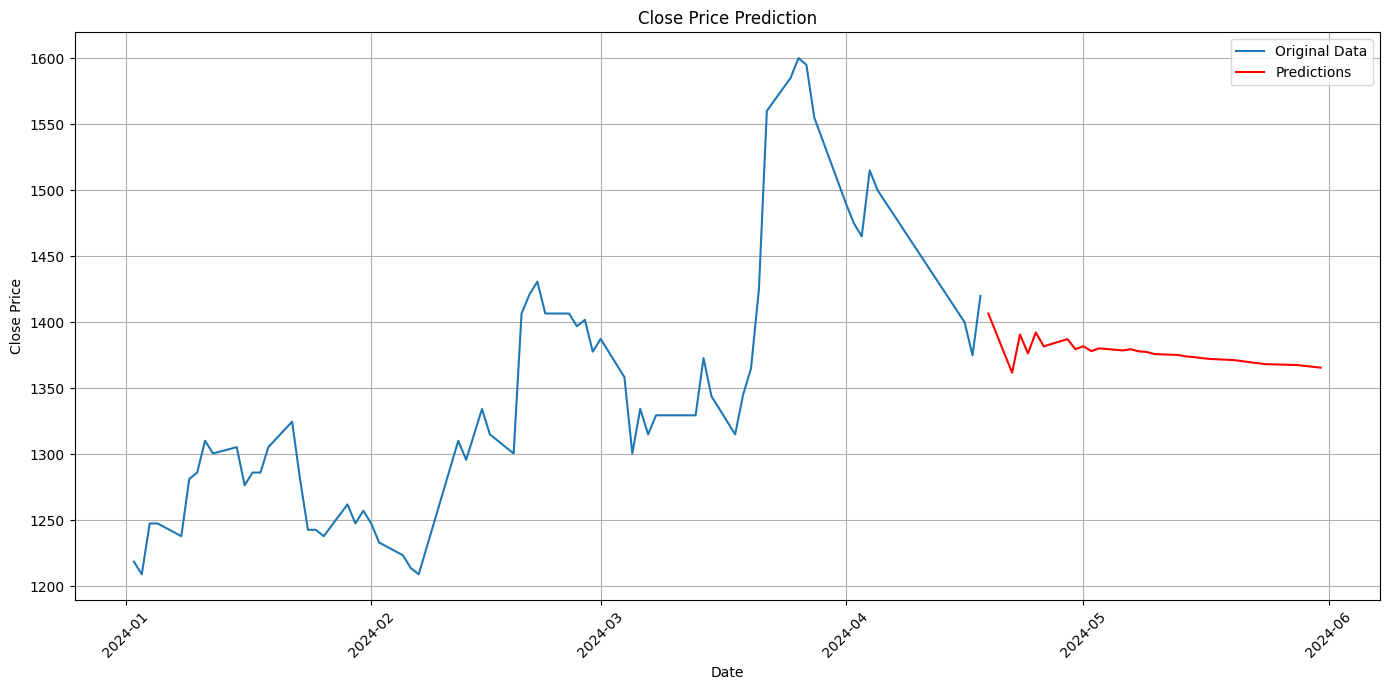

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(df[df['Date'] > '2024-01-01']['Date'], df[df['Date'] > '2024-01-01']['Close'], label='Original Data')

# Plot the predictions
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predictions', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

DataFrame awal:
                                Date         Open         High          Low  \
Date                                                                          
2022-03-25 2022-03-25 00:00:00+07:00  4251.291679  4251.291679  4153.047544   
2022-03-28 2022-03-28 00:00:00+07:00  4224.497559  4233.428843  4170.909852   
2022-03-29 2022-03-29 00:00:00+07:00  4242.360168  4242.360168  4170.909892   
2022-03-30 2022-03-30 00:00:00+07:00  4233.429109  4233.429109  4188.772684   
2022-03-31 2022-03-31 00:00:00+07:00  4197.703653  4242.360075  4161.978516   

                  Close     Volume  Dividends  Stock Splits  
Date                                                         
2022-03-25  4206.635254  137104800        0.0           0.0  
2022-03-28  4224.497559  106801800        0.0           0.0  
2022-03-29  4188.772461   93155100        0.0           0.0  
2022-03-30  4206.635254   83364400        0.0           0.0  
2022-03-31  4161.978516  158650000        0.0           0.

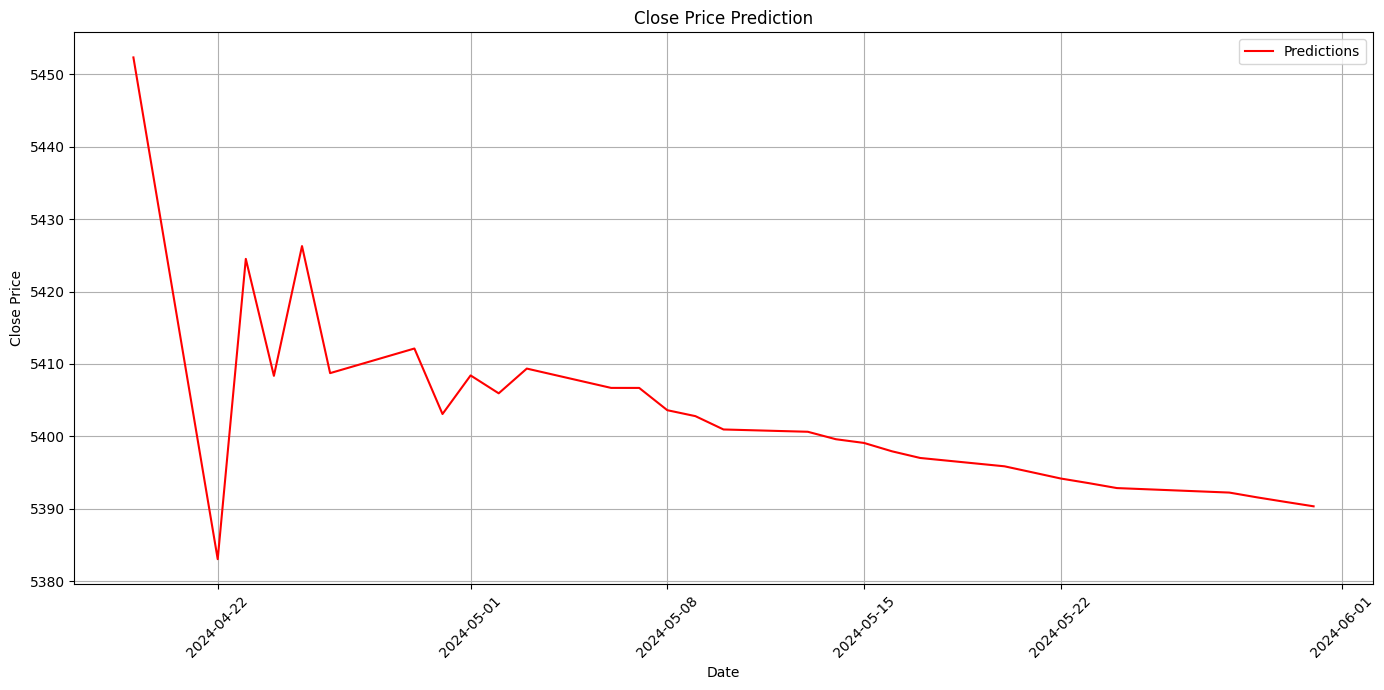

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from pytz import timezone

# Salin DataFrame test_data_bbri_gru
df = test_data_bbri_gru.copy()

# Menampilkan 5 baris pertama dari DataFrame
print("DataFrame awal:")
print(df.head())

# Menampilkan 5 baris terakhir dari DataFrame
print("\nDataFrame akhir:")
print(df.tail())

# 1. Load model
model = load_model('/content/best_model_bbtn_gru_l5.h5')

# 2. Prepare data (gunakan data dari 100 hari terakhir)
last_n_days = 100  # Menggunakan 100 hari terakhir sesuai kebutuhan model
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict multiple business days into the future, skipping weekends and holidays
n_days_to_predict = 30
predictions = []

# Get Jakarta (WIB) timezone
wib_timezone = timezone('Asia/Jakarta')

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get next business day from the last available date in the dataframe
last_date = pd.to_datetime(df['Date'].iloc[-1])

# Convert to Jakarta timezone if not already
if last_date.tzinfo is None:
    last_date = last_date.tz_localize('UTC').astimezone(wib_timezone)
else:
    last_date = last_date.tz_convert(wib_timezone)

current_date = last_date

# List to hold predicted dates
predicted_dates = []

for _ in range(n_days_to_predict):
    # Get next business day
    current_date = nyse.valid_days(start_date=current_date + pd.Timedelta(days=1), end_date=current_date + pd.Timedelta(days=30), tz='Asia/Jakarta')[0]

    # Predict only if it's a business day
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        # Predict
        predicted_scaled = model.predict(data_to_predict_scaled)
        predicted = scaler.inverse_transform(predicted_scaled)

        # Save prediction
        predictions.append(predicted[0][0])

        # Update data_to_predict_scaled for the next prediction
        data_to_predict_scaled = np.append(data_to_predict_scaled[:, 1:, :], np.reshape(predicted_scaled, (1, 1, 1)), axis=1)

        # Save predicted date
        predicted_dates.append(current_date)

# Print the predicted values
print("\nPredicted values for the next business days:")
print(predictions)

# Membuat DataFrame baru untuk hasil prediksi
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Close': predictions})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the predictions only
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predictions', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Using Worst Model

DataFrame awal:
                                Date         Open         High          Low  \
Date                                                                          
2022-03-25 2022-03-25 00:00:00+07:00  4251.291679  4251.291679  4153.047544   
2022-03-28 2022-03-28 00:00:00+07:00  4224.497559  4233.428843  4170.909852   
2022-03-29 2022-03-29 00:00:00+07:00  4242.360168  4242.360168  4170.909892   
2022-03-30 2022-03-30 00:00:00+07:00  4233.429109  4233.429109  4188.772684   
2022-03-31 2022-03-31 00:00:00+07:00  4197.703653  4242.360075  4161.978516   

                  Close     Volume  Dividends  Stock Splits  
Date                                                         
2022-03-25  4206.635254  137104800        0.0           0.0  
2022-03-28  4224.497559  106801800        0.0           0.0  
2022-03-29  4188.772461   93155100        0.0           0.0  
2022-03-30  4206.635254   83364400        0.0           0.0  
2022-03-31  4161.978516  158650000        0.0           0.

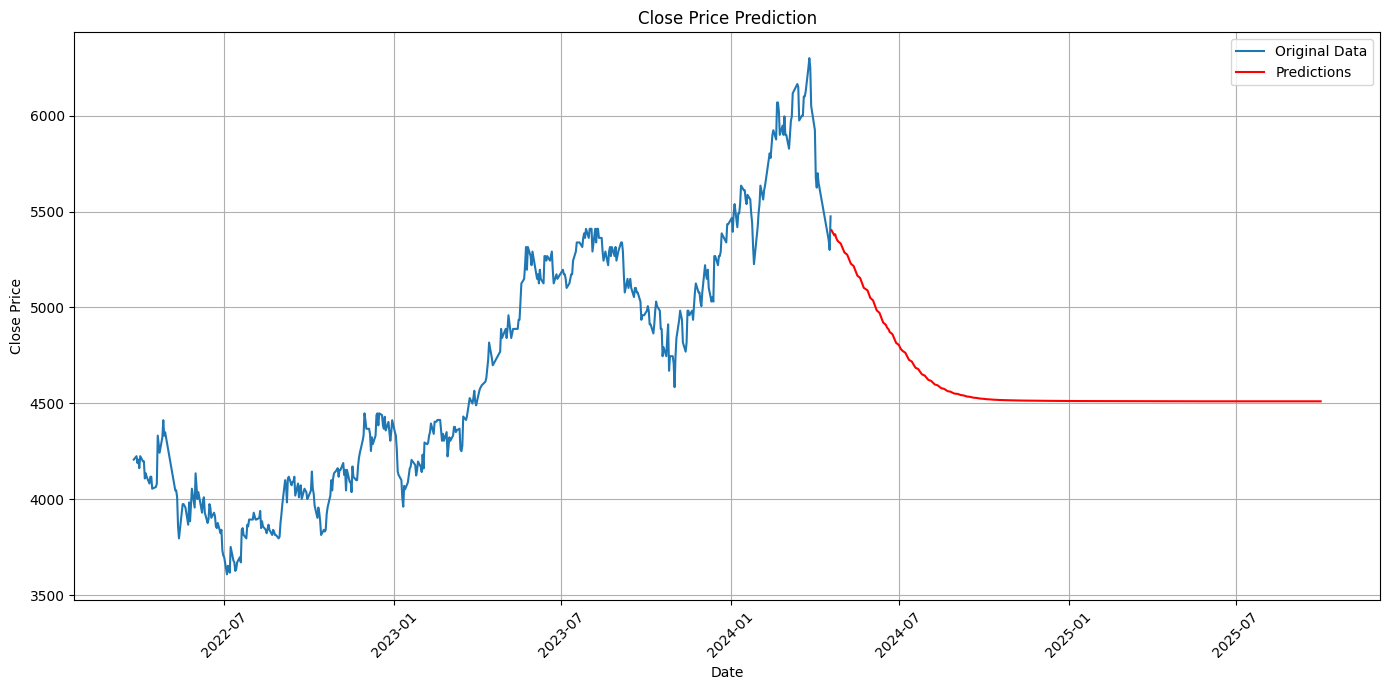

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas_market_calendars as mcal
from pytz import timezone

df = test_data_bbri_gru.copy()

# Menampilkan 5 baris pertama dari DataFrame
print("DataFrame awal:")
print(df.head())

# Menampilkan 5 baris terakhir dari DataFrame
print("\nDataFrame akhir:")
print(df.tail())

# 1. Load model
model = load_model('/content/worst_model_bbtn_gru_l6.h5')

# 2. Prepare data (gunakan data dari 100 hari terakhir)
last_n_days = 100  # Menggunakan 100 hari terakhir sesuai kebutuhan model
data_to_predict = df['Close'][-last_n_days:].values

# 3. Scaling data (misalnya menggunakan MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data_to_predict_scaled = scaler.fit_transform(data_to_predict.reshape(-1, 1))

# 4. Reshape data
data_to_predict_scaled = np.reshape(data_to_predict_scaled, (1, last_n_days, 1))

# 5. Predict multiple business days into the future, skipping weekends and holidays
n_days_to_predict = 365
predictions = []

# Get Jakarta (WIB) timezone
wib_timezone = timezone('Asia/Jakarta')

# Get NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get next business day from the last available date in the dataframe
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta
current_date = last_date

# List to hold predicted dates
predicted_dates = []

for _ in range(n_days_to_predict):
    # Get next business day
    current_date = nyse.valid_days(start_date=current_date + pd.Timedelta(days=1), end_date=current_date + pd.Timedelta(days=30), tz='Asia/Jakarta')[0]

    # Predict only if it's a business day
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        # Predict
        predicted_scaled = model.predict(data_to_predict_scaled)
        predicted = scaler.inverse_transform(predicted_scaled)

        # Save prediction
        predictions.append(predicted[0][0])

        # Update data_to_predict_scaled for the next prediction
        data_to_predict_scaled = np.append(data_to_predict_scaled[:, 1:, :], np.reshape(predicted_scaled, (1, 1, 1)), axis=1)

        # Save predicted date
        predicted_dates.append(current_date)

# Print the predicted values
print("\nPredicted values for the next business days:")
print(predictions)

# Mendapatkan tanggal terakhir dari data asli
last_date = df['Date'].iloc[-1].astimezone(wib_timezone)  # Konversi ke zona waktu Jakarta

# Membuat DataFrame baru untuk hasil prediksi
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Close': predictions})

# Menampilkan DataFrame prediksi
print("\nPrediction DataFrame:")
print(prediction_df)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the original data
plt.plot(df['Date'], df['Close'], label='Original Data')

# Plot the predictions
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predictions', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Membaca kedua file CSV
df1 = pd.read_csv('/content/bbri_predict.csv')
df2 = pd.read_csv('/content/bbtn_predict.csv')

# Menggabungkan kedua DataFrame
df_gabung = pd.merge(df1, df2, on='Date')

# Menyimpan hasil penggabungan ke file CSV baru
df_gabung.to_csv('predicted_BTN_BRI.csv', index=False)